In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt                # импортируем библиотеки
import seaborn as sns
import numpy as np

%matplotlib inline

In [5]:
# считываем данные
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-demidov-20/PYTHON/saber_test.csv.zip', 
                                                                                     compression='zip', 
                                                                                     low_memory=False)

In [153]:
# посмотрим на датасет, на типы данных
df.head(1)

,name,multiverse_id,layout,names,mana_cost,cmc,colors,color_identity,type,supertypes,...,original_type,legalities,source,image_url,set,set_name,id,color_distr,banned_commander,land
0,Ancestor's Chosen,130550.0,normal,NaN,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,NaN,...,Creature - Human Cleric,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,White,0,0


In [154]:
df.dtypes.head(5)

name              object
multiverse_id    float64
layout            object
names            float64
mana_cost         object
dtype: object

# Задание 1. Распределение карт по цвету в зависимости от редкости.

Чтобы решить это задание, для начала посмотрим на колонку цветов, а также заглянем в МТГ-Вики, чтобы почитать про цвета карт, и что они означают(ниже есть описание). После этого предположим, что если у карты не один цвет, а несколько, то будем считать ее "многоцветной"("золотой"), а если цвета нет, то "бесцветной".

In [157]:
df.colors.unique()

array(["['White']", "['Blue']", "['Black']", "['Red']", "['Green']", '0',
       "['Green', 'Blue']", "['Black', 'Green', 'Blue', 'White']",
       "['Black', 'Blue']", "['Black', 'Red', 'Blue', 'White']",
       "['Red', 'Blue']", "['Black', 'Green']", "['Black', 'Red']",
       "['Blue', 'White']", "['Green', 'Red']", "['Black', 'White']",
       "['Black', 'Red', 'White']", "['Black', 'Green', 'Red']",
       "['Black', 'Green', 'Red', 'Blue', 'White']", "['Green', 'White']",
       "['Green', 'Red', 'Blue']", "['Black', 'Blue', 'White']",
       "['Red', 'White']", "['Black', 'Red', 'Blue']",
       "['Green', 'Blue', 'White']", "['Green', 'Red', 'White']",
       "['Black', 'Green', 'Blue']", "['Red', 'Blue', 'White']",
       "['Black', 'Green', 'White']", "['Green', 'Red', 'Blue', 'White']",
       "['Black', 'Green', 'Red', 'White']",
       "['Black', 'Green', 'Red', 'Blue']", "['White', 'Blue']",
       "['Blue', 'Black']", "['Blue', 'Green']", "['White', 'Red']",
       "['B

In [158]:
# для начала для удобства заменим пропущенные значения
df['colors'] = df.colors.fillna('0')

В Магии и мана, и карты бывают только пяти следующих цветов:
-Белые (White)
-Синие (Blue)
-Чёрные (Black)
-Красные (Red)
-Зеленые (Green)

Многоцветные («золотые») карты — имеющие несколько цветов. Многие из этих карт имеют характерную жёлтую («золотую») рамочку. Отметим, что карта, в мановой стоимости которой присутствуют несколько цветов одновременно, относится к каждому из этих цветов. Например, карта, имеющая мановую стоимость 1RG будет одновременно и зелёной, и красной. 

Таким образом, «многоцветный», «красно-зелёный» и другие подобные эпитеты не являются отдельными цветами. Некоторые многоцветные карты блоков Ravnica и Shadowmoor имеют рамку тех цветов, которые имеет сама карта — это не несёт игрового значения. Эти карты содержат в своей стоимости гибридные символы маны. Такая единица стоимости может быть оплачена маной одного из двух цветов. Вне зависимости от того, какая мана была потрачена на оплату, карта попрежнему имеет оба цвета.


Бесцветные карты не имеют цвета. Примерами бесцветных карт являются земли и большинство артефактов. «Бесцветный» — это не цвет, а отсутствие цвета.
Цвет карты может влиять на её оформление, но не наоборот. Согласно правилам, цвет карты определяется цветами мановых символов, содержащейся в ее мановой стоимости, цветовым маркером или способностью, определяющей характеристики. Таким образом, большинство земель являются бесцветными, потому что не имеют ни мановой стоимости, ни цветового маркера. Цвет карты может быть изменен игровыми эффектами.

In [10]:
# создадим функицю, которая будет нам отбирать карты по цвету
import re 
def color_set(colors):
    a = re.findall(r"'\s*([^']*?)\s*'", colors)
    if len(a) > 1:
        return 'Multicolor/Gold'
    elif a == []:
        return 'Colorless'
    else:
        return a[0]

In [11]:
# проверим работу функции
color_set("['Black', 'Green', 'Red', 'Blue']")

'Multicolor/Gold'

In [12]:
color_set("['Blue']")

'Blue'

In [13]:
color_set('0')

'Colorless'

In [14]:
# применим ее к колонке цвета
df['color_distr'] = df.colors.apply(color_set)

In [15]:
# сгруппируем по цвету и редкости, посчитаем количество карт, сколько на каждый цвет приходится по редкости
dff = df.groupby(['color_distr', 'rarity'], as_index=False) \
    .agg({'color_identity': 'count'}) \
    .rename(columns={'color_identity': 'number_of_cards', 
                    'color_distr': 'color'})
dff.head()


,color,rarity,number_of_cards
0,Black,Common,3242
1,Black,Mythic,535
2,Black,Rare,2927
3,Black,Special,34
4,Black,Uncommon,2429


In [16]:
# здесь посчтитает общее распределение по цвету , для добавления на общий график
df_1 = df.groupby('color_distr', as_index=False) \
    .agg({'color_identity': 'count'}) \
    .rename(columns={'color_identity': 'number_of_cards', 
                    'color_distr': 'color'})
df_1.color

0              Black
1               Blue
2          Colorless
3              Green
4    Multicolor/Gold
5                Red
6              White
Name: color, dtype: object

In [17]:
# для удобства зададим отдельные значения для каждого графика
sizes_black = dff[dff.color == 'Black'].number_of_cards
sizes_blue = dff[dff.color == 'Blue'].number_of_cards
sizes_colorless = dff[dff.color == 'Colorless'].number_of_cards
sizes_green = dff[dff.color == 'Green'].number_of_cards
sizes_multi = dff[dff.color == 'Multicolor/Gold'].number_of_cards
sizes_red = dff[dff.color == 'Red'].number_of_cards
sizes_white = dff[dff.color == 'White'].number_of_cards

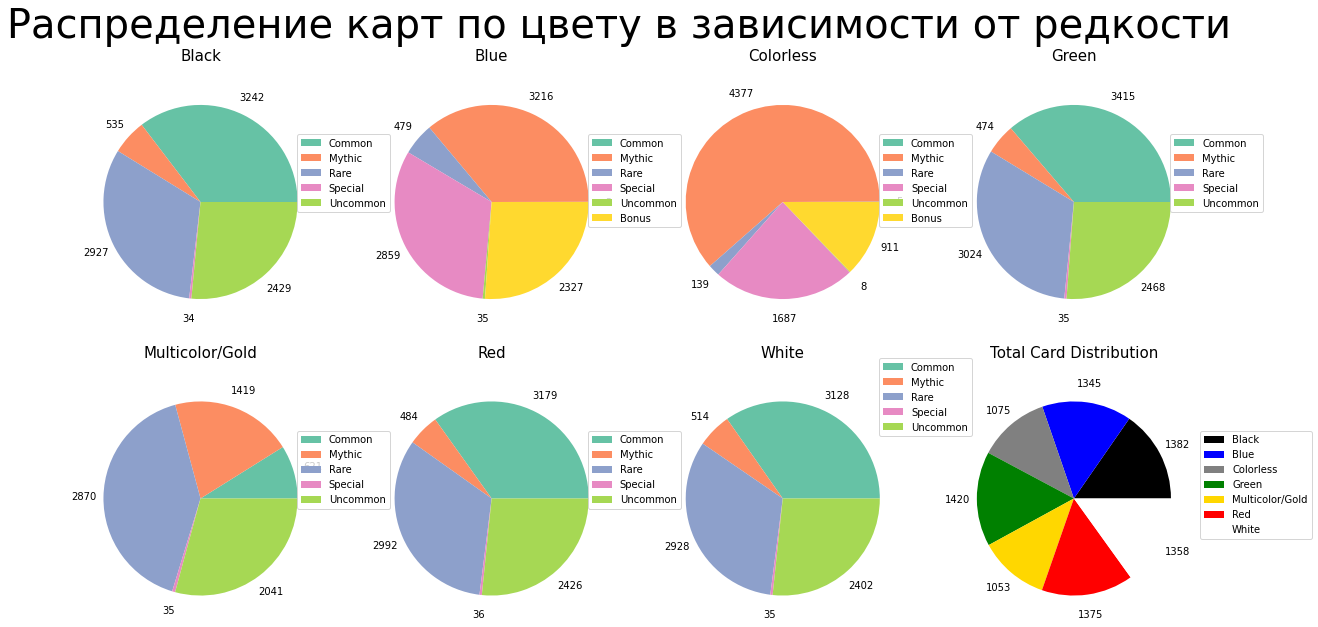

In [18]:
# создадим большой график(я выбрал диаграмму), чтобы посмотреть и сравнить распределение карт по цвету в зависимости от редкости
figure, axis = plt.subplots(2, 4, figsize=(20,10))
plt.suptitle('Распределение карт по цвету в зависимости от редкости', fontsize=40)
labels = dff.rarity
colorss = sns.color_palette("Set2")

axis[0,0].pie(sizes_black, colors=colorss, autopct=lambda x: '{:.0f}'.format(x*sizes_black.sum()/100),pctdistance=1.2)
axis[0,0].set_title("Black",pad =20,fontsize=15)
axis[0,0].legend(labels=labels,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.5, 0.5))

axis[0,1].pie(sizes_blue, colors=colorss, autopct=lambda x: '{:.0f}'.format(x*sizes_blue.sum()/100),pctdistance=1.2)
axis[0,1].set_title("Blue",pad =20,fontsize=15)
axis[0,1].legend(labels=labels,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.5, 0.5))

axis[0,2].pie(sizes_colorless, colors=colorss, autopct=lambda x: '{:.0f}'.format(x*sizes_colorless.sum()/100),pctdistance=1.2)
axis[0,2].set_title("Colorless",pad =20,fontsize=15)
axis[0,2].legend(labels=labels,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.5, 0.5))

axis[0,3].pie(sizes_green, colors=colorss, autopct=lambda x: '{:.0f}'.format(x*sizes_green.sum()/100),pctdistance=1.2)
axis[0,3].set_title("Green",pad =20,fontsize=15)
axis[0,3].legend(labels=labels,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.5, 0.5))

axis[1,0].pie(sizes_multi, colors=colorss, autopct=lambda x: '{:.0f}'.format(x*sizes_multi.sum()/100),pctdistance=1.2)
axis[1,0].set_title("Multicolor/Gold",pad =20,fontsize=15)
axis[1,0].legend(labels=labels,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.5, 0.5))

axis[1,1].pie(sizes_red, colors=colorss, autopct=lambda x: '{:.0f}'.format(x*sizes_red.sum()/100),pctdistance=1.2)
axis[1,1].set_title("Red",pad =20,fontsize=15)
axis[1,1].legend(labels=labels,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.5, 0.5))

axis[1,2].pie(sizes_white, colors=colorss, autopct=lambda x: '{:.0f}'.format(x*sizes_white.sum()/100),pctdistance=1.2)
axis[1,2].set_title("White",pad =20,fontsize=15)
axis[1,2].legend(labels=labels,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.5, 0.8))

axis[1,3].pie(df_1.number_of_cards, colors=['Black', 'Blue', 'Grey', 'Green','Gold', 'Red','White'], autopct=lambda x: '{:.0f}'.format(x*sizes_white.sum()/100),pctdistance=1.2)
axis[1,3].set_title("Total Card Distribution",pad =20,fontsize=15)
axis[1,3].legend(labels=df_1.color,frameon=True,bbox_to_anchor=(0.8, 0.3, 0.7, 0.5))

Данный график можно проанализировать разными способами. Например, мы видим, что примерно одинаковое количество цветов(Total Card Distribution), то есть карты распределены практически равномерно. Также можно посмотреть , где преобладают или отсутствуют разной редкости карты, например, бесцветных карт больше всего мифичесикх, также, как и синих, а многоцветных\золотых больше всего редких и так далее.

Также видим, что среди синих больше всего спэшл карт по сравнению со всеми цветами. 

Есть и второй вариант решения, взять, к примеру, и поделить все карты по цветам, и посмотреть на распределение без многоцветных, а также использовать другой тип графиков,но мне было понятнее смотреть на типы карт с использованием диаграмм.

# Задание 2. Процент карт, запрещенных в формате Commander, а также распределение по типу для этих карт.

В этом задании найдем карты, запрещенные(Banned) в формате Commander, и посмотрим на рапределение по типу для этих карт.

In [19]:
# для начала посмотрим, как выглядят значения в колонке legalities
df.legalities[0]

"[{'format': 'Commander', 'legality': 'Legal'}, {'format': 'Duel', 'legality': 'Legal'}, {'format': 'Legacy', 'legality': 'Legal'}, {'format': 'Modern', 'legality': 'Legal'}, {'format': 'Paupercommander', 'legality': 'Restricted'}, {'format': 'Penny', 'legality': 'Legal'}, {'format': 'Premodern', 'legality': 'Legal'}, {'format': 'Vintage', 'legality': 'Legal'}]"

In [20]:
# самый простой способ, создать функцию, которыя найдет в строке нужное нам сочетание букв и символов
def find_banned_commander(legality):
    if "{'format': 'Commander', 'legality': 'Banned'}" in legality:
        return 1
    else:
        return 0

In [21]:
df['legalities'] = df['legalities'].fillna('0')

In [22]:
# добавим колонку к исходному датасету, по которой мы будем отбирать нужные нам строки, и применим функицю
df['banned_commander'] = df.legalities.apply(find_banned_commander)

In [23]:
# здесь отберем только те значения, в которых format = Commander, legality = Banned
df[df.banned_commander == 1].head() 

,name,multiverse_id,layout,names,mana_cost,cmc,colors,color_identity,type,supertypes,...,original_text,original_type,legalities,source,image_url,set,set_name,id,color_distr,banned_commander
510,Balance,831.0,normal,NaN,{1}{W},2.0,['White'],['W'],Sorcery,NaN,...,Whichever player has more lands in play must d...,Sorcery,"[{'format': 'Commander', 'legality': 'Banned'}...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,59b60f89-e041-57a4-aef1-930d44cb5de5,White,1
524,Crusade,845.0,normal,NaN,{W}{W},2.0,['White'],['W'],Enchantment,NaN,...,All white creatures gain +1/+1.,Enchantment,"[{'format': 'Commander', 'legality': 'Banned'}...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,14d81598-d876-550f-8813-0f4ba177c888,White,1
555,Ancestral Recall,692.0,normal,NaN,{U},1.0,['Blue'],['U'],Instant,NaN,...,Draw 3 cards or force opponent to draw 3 cards.,Instant,"[{'format': 'Commander', 'legality': 'Banned'}...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,89470421-c7fa-5cc1-9bce-ccbbb02b5a06,Blue,1
591,Time Walk,728.0,normal,NaN,{1}{U},2.0,['Blue'],['U'],Sorcery,NaN,...,Take an extra turn after this one.,Sorcery,"[{'format': 'Commander', 'legality': 'Banned'}...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,1efe8ae8-d268-54c2-b47a-71f11bd72934,Blue,1
604,Contract from Below,649.0,normal,NaN,{B},1.0,['Black'],['B'],Sorcery,NaN,...,Discard your current hand and draw eight new c...,Sorcery,"[{'format': 'Commander', 'legality': 'Banned'}...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,2ED,Unlimited Edition,60124c14-dc29-5c80-af4e-620dc2020046,Black,1


In [160]:
# посчитаем процент от общего числа карт, поделив на размер датасета, это можно сделать, так как все id карточек уникальные
(df[df.banned_commander == 1].shape[0] / df.shape[0]) * 100 

0.525685187958664

0.53 % карт, запрещенных в формате Commander

In [161]:
# сгруппируем данные по типу карты, и посчитаем их число
banned_commander_cards_by_type = df[df.banned_commander == 1].groupby('type', as_index=False) \
                                                             .agg({'id': 'count'}) \
                                                             .rename(columns={'id': 'number_of_cards'}) \
                                                             .sort_values('number_of_cards', ascending=False)
banned_commander_cards_by_type

,type,number_of_cards
27,Sorcery,96
0,Artifact,81
11,Enchantment,36
2,Conspiracy,26
13,Instant,19
26,Legendary Land,12
19,Legendary Creature — Eldrazi,9
6,Creature — Giant,7
18,Legendary Creature — Demon,7
8,Creature — Human Nomad,6


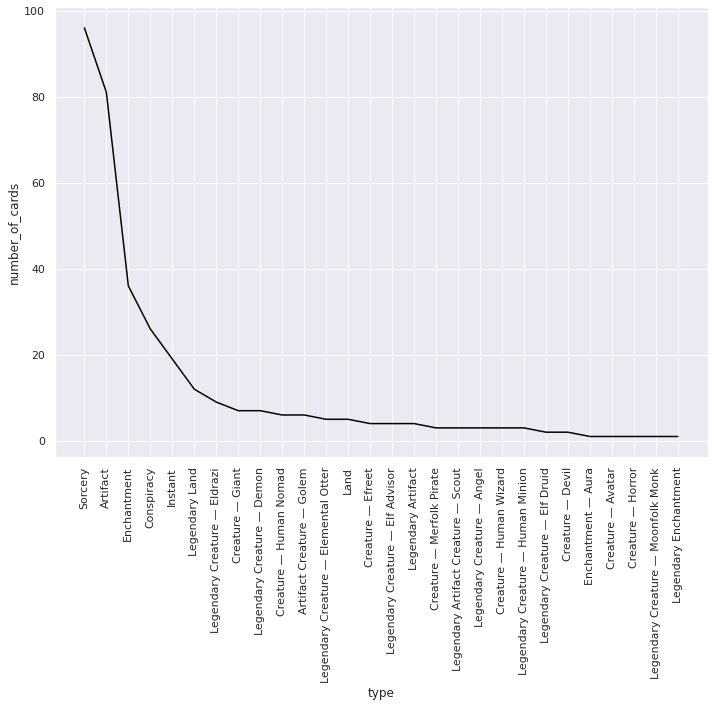

In [26]:
# посстроим простенький график распределения нужных нам карт по типу
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data=banned_commander_cards_by_type, x='type',y = 'number_of_cards',color='black')
plt.xticks(rotation=90)
plt.show()

На графике представлено распределение по типу для карт, запрещенных в формате Commander. Как можно заметить, большего всего карт типа Artifact и Sorcery, а меньше всего Enchantment — Aura, Creature — Avatar, Creature — Horror, Legendary Creature — Moonfolk Monk и Legendary Enchantment	

# Задание 3. Топ-10 карт, не являющихся землями, которые были напечатаны в наибольшем количестве сетов.

Посмотрим на топ 10 карты, которые не являются землей, для этого отберем карты, в описании которых встречаетсся слово 'Land'
Далее уберем их из датасета. После этого, так как я не совсем понял, по чему будет идти отбор, по типу карты, или по имени, на всякий случай посчитаем для обоих вариантов.

In [38]:
# напишем простую функцию
def find_land(types):
    if 'Land' in types:
        return 1
    else:
        return 0

In [39]:
df['land'] = df.type.apply(find_land)

In [43]:
# в новый датасет положим данные без карт земли
df_without_land = df[df.land == 0]

In [58]:
# здесь отберем топ-10 по типу карт, и посчитав, сколько они встречаются в сетах и отсортировав,
# посмотрим на 10 наиболее часто встречающихся карт
# группируем по типу, считаем число уникальных сетов, в которых попадалась эта карта, и сортируем по убыванию
top_10_1 = df_without_land.groupby(['type'], as_index=False) \
                .agg({'set_name': pd.Series.nunique}) \
                .sort_values('set_name', ascending=False).head(10) \
                .rename(columns={'set_name': 'number_of sets'})
top_10_1

,type,number_of sets
1629,Instant,392
2286,Sorcery,384
1526,Enchantment,327
0,Artifact,299
1602,Enchantment — Aura,255
842,Creature — Human Wizard,227
448,Creature — Elemental,218
816,Creature — Human Soldier,184
182,Creature — Angel,182
390,Creature — Dragon,181


Итого, топ-10 карт по типу:
1. Instant	
2. Sorcery
3. Enchantment
4. Artifact	
5. Enchantment — Aura
6. Creature — Human Wizard	
7. Creature — Elemental	
8. Creature — Human Soldier
9. Creature — Angel	
10. Creature — Dragon	

In [60]:
# здесь уже посмотрим на топ-10 по названию карты
top_10_2 = df_without_land.groupby(['name'], as_index=False) \
                .agg({'set_name': pd.Series.nunique}) \
                .sort_values('set_name', ascending=False).head(10) \
                .rename(columns={'set_name': 'number_of sets'})
top_10_2

,name,number_of sets
7888,Giant Growth,47
3948,Counterspell,46
17518,Serra Angel,42
19851,Swords to Plowshares,42
4457,Dark Ritual,41
5128,Disenchant,41
18511,Sol Ring,41
11653,Llanowar Elves,40
6983,Fireball,35
355,Air Elemental,33


Итого, топ-10 карт по названию:

1. Giant Growth
2. Counterspell
3. Serra Angel	
4. Swords to Plowshares
5. Dark Ritual	
6. Disenchant
7. Sol Ring
8. Llanowar Elves
9. Fireball
10. Air Elemental

# Задание 4. Для карт, не являющихся землями, определите, какая часть из них даёт ману с помощью своего эффекта. Покажите распределение по типу маны, который дают эти карты. 

In [70]:
df_without_land.head()

,name,multiverse_id,layout,names,mana_cost,cmc,colors,color_identity,type,supertypes,...,original_type,legalities,source,image_url,set,set_name,id,color_distr,banned_commander,land
0,Ancestor's Chosen,130550.0,normal,NaN,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,NaN,...,Creature - Human Cleric,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,White,0,0
1,Ancestor's Chosen,NaN,normal,NaN,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,NaN,...,NaN,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,NaN,10E,Tenth Edition,b7c19924-b4bf-56fc-aa73-f586e940bd42,White,0,0
2,Angel of Mercy,129465.0,normal,NaN,{4}{W},5.0,['White'],['W'],Creature — Angel,NaN,...,Creature - Angel,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,White,0,0
3,Angel of Mercy,NaN,normal,NaN,{4}{W},5.0,['White'],['W'],Creature — Angel,NaN,...,NaN,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,NaN,10E,Tenth Edition,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a,White,0,0
4,Angelic Blessing,129711.0,normal,NaN,{2}{W},3.0,['White'],['W'],Sorcery,NaN,...,Sorcery,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,White,0,0


In [68]:
# cmc - converted mana cost

In [78]:
df_without_land.cmc.unique()

array([7.0e+00, 5.0e+00, 3.0e+00, 2.0e+00, 4.0e+00, 1.0e+00, 6.0e+00,
       9.0e+00, 8.0e+00, 1.0e+01, 0.0e+00, 1.2e+01, 1.4e+01, 1.1e+01,
       1.6e+01, 1.3e+01, 1.5e+01, 5.0e-01, 1.0e+06])

In [84]:
df_without_land[df_without_land.cmc > 0].shape[0] / df_without_land.shape[0] * 100

98.52816925208693

Если я правильно понял, то карты, которые дают ману,это те карты, у которых cmc > 0, и если это так, то
98,5 % карт дают ману с помощью своего эффекта

In [106]:
mana_distr = df_without_land[df_without_land.cmc > 0].groupby('color_distr', as_index=False) \
                                        .agg({'cmc': 'sum'})
mana_distr

,color_distr,cmc
0,Black,30786.0
1,Blue,29983.0
2,Colorless,2019312.0
3,Green,31702.0
4,Multicolor/Gold,27258.0
5,Red,30133.0
6,White,28509.5


In [105]:
df_without_land[df_without_land.cmc > 16].name[61804]

'Gleemax'

Если говорить о распределении по типу маны, а как я смог выяснить, цвет - это и есть тип маны, то распределение примерно равномерное(это говорит в целом о балансе в игре), не считая одной карты, Gleemax, которая бесцветная, и у нее cmc = 1 000 000, и таких карт было выпущено 2 штуки.


"Игроки используют ману для оплаты различных стоимостей, как правило, при розыгрыше заклинаний и активации способностей. 106.1a Существует пять цветов маны: белая, синяя, черная, красная и зеленая. 106.1b Существует шесть типов маны: белый, синий, черный, красный, зеленый и бесцветный."(с)
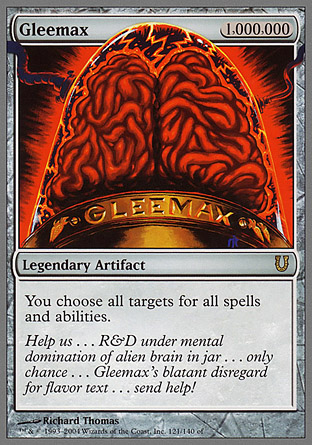

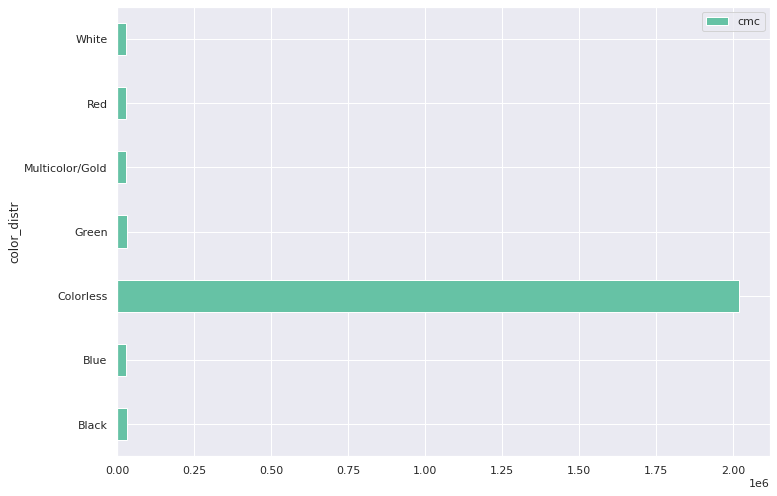

In [139]:
mana_distr.set_index('color_distr').plot(kind='barh', color=sns.color_palette("Set2"))

In [149]:
mana_distr_without_gleemax = df_without_land[(df_without_land.cmc > 0 )& (df_without_land.cmc < 20)] \
                                .groupby('color_distr') \
                                .agg({'cmc': 'sum'})
mana_distr_without_gleemax

,cmc
color_distr,
Black,30786.0
Blue,29983.0
Colorless,19312.0
Green,31702.0
Multicolor/Gold,27258.0
Red,30133.0
White,28509.5


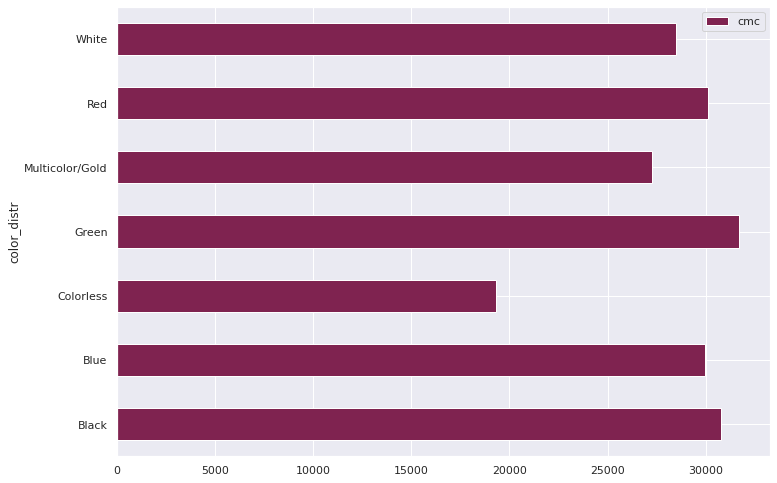

In [150]:
# график распределения без 
mana_distr_without_gleemax.plot(kind='barh', color=sns.color_palette('twilight_shifted_r'))